# Imports and Preparing the data of behavior.tsv and news.tsv #

In [16]:
import pandas as pd
from pathlib import Path
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.decomposition import IncrementalPCA
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import combinations

# Load the data
base_path = Path.cwd() / 'data'
news_path = base_path / 'news.tsv'
behaviors_path = base_path / 'behaviors.tsv'

news = pd.read_csv(news_path, sep='\t', names=['news_id', 'category', 'subcategory', 'title', 'abstract', 'url', 'title_entities', 'abstract_entities'])
behaviors = pd.read_csv(behaviors_path, sep='\t', names=['impression_id', 'user_id', 'time', 'history', 'impressions'])

# Preprocessing with Data Cleaning Remove duplicates and Text cleaning

In [17]:
# Data Cleaning
# Check if attributes such as Category, Subcategory, Title, and Abstract in news.tsv are complete.
# Remove news items with many missing values or replace them with:
# Category: unknown
# Subcategory: general
# Title and Abstract: a placeholder text like "Missing Data."
# For behaviors.tsv, remove users with missing or empty history.
news.fillna({'category': 'unknown', 'subcategory': 'general', 'title': 'Missing Title', 'abstract': 'Missing Abstract'}, inplace=True)
news.dropna(subset=['category', 'subcategory', 'title', 'abstract'], inplace=True)
behaviors.dropna(subset=['history', 'impressions'], inplace=True)

# Remove duplicates
# Remove news items in news.tsv that have the same values for Title and Abstract.
# Remove duplicate impressions (Impression ID) in behaviors.tsv
news.drop_duplicates(subset=['title', 'abstract'], inplace=True)
behaviors.drop_duplicates(subset=['impression_id'], inplace=True)

# Text cleaning
# Break down Title and Abstract into tokens:
# Remove special characters, numbers, and HTML.
# Convert all words to lowercase.
# Remove stopwords (e.g., using nltk or spacy).
# Perform lemmatization to reduce words to their base form.
def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(str(text).lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

def preprocess_text_parallel(texts):
    processed_texts = [preprocess_text(text) for text in texts]
    return processed_texts

# Clean Title and Abstract
news['clean_title'] = preprocess_text_parallel(news['title'])
news['clean_abstract'] = preprocess_text_parallel(news['abstract'])

# Data Preparation with TF-IDF, One-hot, PCA and KMeans

In [18]:
#TF-IDF
# Convert clean_title and clean_abstract into numerical vectors
tfidf_vectorizer = TfidfVectorizer(max_features=500)
tfidf_title = tfidf_vectorizer.fit_transform(news['clean_title'])
tfidf_abstract = tfidf_vectorizer.fit_transform(news['clean_abstract'])

# Combine sparse matrices
news_features = hstack([tfidf_title, tfidf_abstract])

# One-hot encode categories and subcategories
category_encoded = pd.get_dummies(news['category'])
subcategory_encoded = pd.get_dummies(news['subcategory'])

# Combine categorical and TF-IDF features
final_features = hstack([news_features, category_encoded.values, subcategory_encoded.values])

# PCA for faster processing instead of t-SNE for better visualization
pca = IncrementalPCA(n_components=50, batch_size=1000)
reduced_features = pca.fit_transform(news_features)

# Clustering with MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=6, random_state=42, batch_size=500)
news['cluster'] = kmeans.fit_predict(reduced_features)

# PC-Y Algorithm on all articles

Number of frequent items: 227
Number of frequent pairs: 23
  News ID 1                                            Title 1 News ID 2  \
0    N45794  Four flight attendants were arrested in Miami'...    N31801   
1      N871  Woman, suspect dead at 'Tarzan' actor Ron Ely'...    N43142   
2    N45794  Four flight attendants were arrested in Miami'...      N306   
3      N306  Kevin Spacey Won't Be Charged in Sexual Assaul...    N42620   
4    N31801  Joe Biden reportedly denied Communion at a Sou...    N42620   
5    N61864                               The News In Cartoons    N47020   
6    N16715  Mitch McConnell snubbed by Elijah Cummings' pa...    N31801   
7      N871  Woman, suspect dead at 'Tarzan' actor Ron Ely'...     N4020   
8      N871  Woman, suspect dead at 'Tarzan' actor Ron Ely'...    N45794   
9    N51706  Former NFL lineman Justin Bannan arrested for ...    N43142   

                                             Title 2  Support Count  
0  Joe Biden reportedly denied Com

C:\Users\stefa\AppData\Local\Temp\ipykernel_20096\565081151.py:84: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


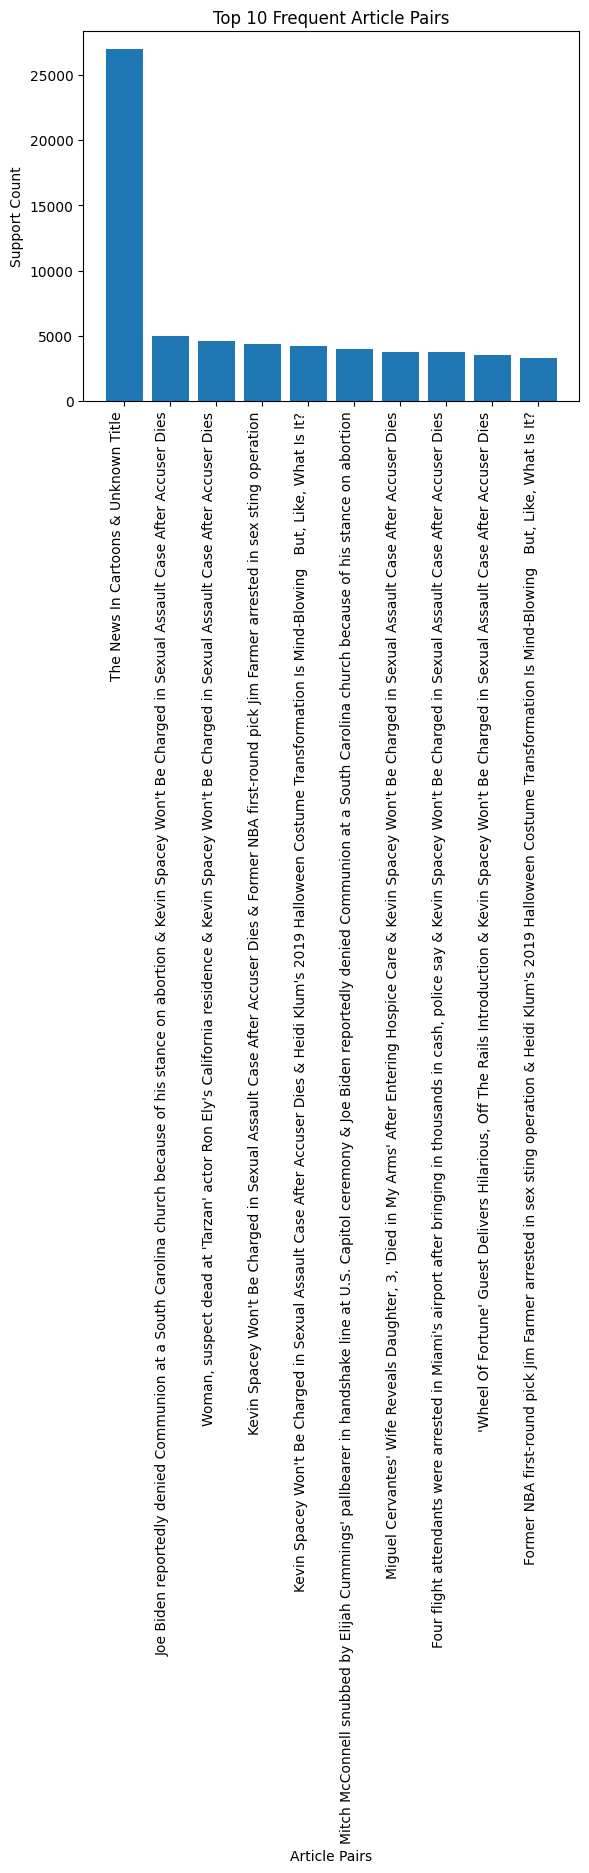

In [19]:
news_title_dict = dict(zip(news['news_id'], news['title']))

# only needed for APriori, problem with implementation in APriori !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
old_behaviors = behaviors.copy()

# Split 'history' into lists of baskets based on ids
behaviors['history'] = behaviors['history'].fillna('').apply(lambda x: x.split())
baskets = behaviors['history'].tolist()

# Pass 1 of the PC-Y algorithm: Count individual items and hash pairs
# Define parameters
min_support = 3000  # ~2% of 157,000 rows
hash_table_size = 200000  # Size of the hash table

# Initialize counters
item_count = defaultdict(int)
hash_table = [0] * hash_table_size

# Count individual items and hash pairs, skipping self-pairs
for basket in baskets:
    for item in basket:
        item_count[item] += 1

    # Generate item pairs using combinations and skip self-pairs
    for pair in combinations(basket, 2):
        # Skip self-pairs
        if pair[0] == pair[1]:
            continue

        hash_index = (hash(pair[0]) + hash(pair[1])) % hash_table_size
        hash_table[hash_index] += 1

# Create a bitmap based on the minimum support threshold
bitmap = [1 if count >= min_support else 0 for count in hash_table]

# Filter out infrequent items
frequent_items = {item for item, count in item_count.items() if count >= min_support}
print(f"Number of frequent items: {len(frequent_items)}")

#Pass 2
candidate_pairs = defaultdict(int)

for basket in baskets:
    # Filter to include only frequent items
    filtered_basket = [item for item in basket if item in frequent_items]

    for pair in combinations(filtered_basket, 2):
        # Skip self-pairs
        if pair[0] == pair[1]:
            continue

        hash_index = (hash(pair[0]) + hash(pair[1])) % hash_table_size
        if bitmap[hash_index]:
            candidate_pairs[pair] += 1

#identify frequent pairs
frequent_pairs = {pair: count for pair, count in candidate_pairs.items() if count >= min_support}
print(f"Number of frequent pairs: {len(frequent_pairs)}")

#enrich Frequent pairs with Article Titels 
enriched_pairs = []

for (news_id1, news_id2), count in frequent_pairs.items():
    title1 = news_title_dict.get(news_id1, "Unknown Title")
    title2 = news_title_dict.get(news_id2, "Unknown Title")
    enriched_pairs.append((news_id1, title1, news_id2, title2, count))

# Convert to a DataFrame for easier viewing
enriched_df = pd.DataFrame(enriched_pairs, columns=['News ID 1', 'Title 1', 'News ID 2', 'Title 2', 'Support Count'])

# Display the top 10 enriched frequent pairs
print(enriched_df.head(10))

#Visualize the Top 10 Frequent Pairs

top_frequent_pairs = enriched_df.sort_values(by='Support Count', ascending=False).head(10)
pairs = [f"{row['Title 1']} & {row['Title 2']}" for _, row in top_frequent_pairs.iterrows()]
counts = top_frequent_pairs['Support Count'].tolist()

plt.bar(pairs, counts)
plt.xticks(rotation=90, ha='right')
plt.xlabel("Article Pairs")
plt.ylabel("Support Count")
plt.title("Top 10 Frequent Article Pairs")
plt.tight_layout()
plt.show()

# PC-Y Algorithm based on Clusters

Number of frequent items: 227


C:\Users\stefa\AppData\Local\Temp\ipykernel_20096\3369974840.py:84: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


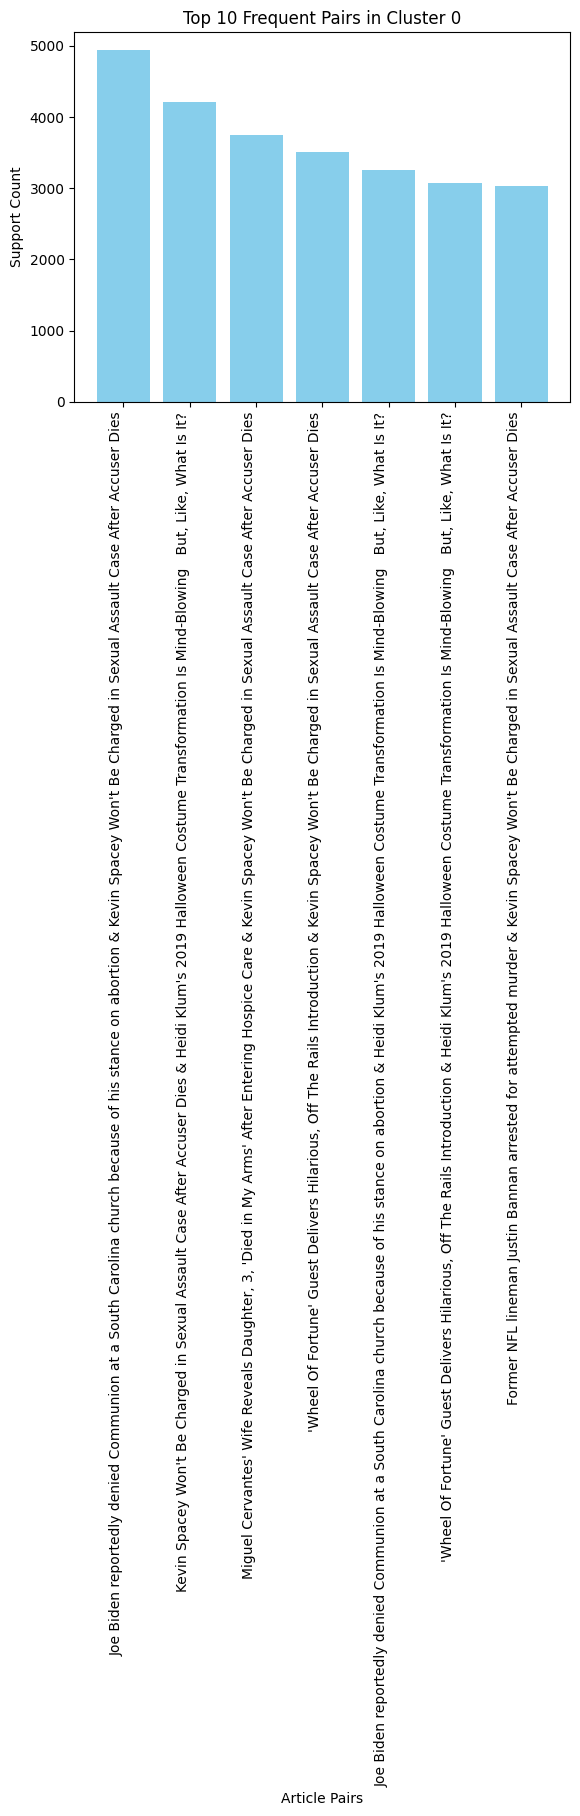

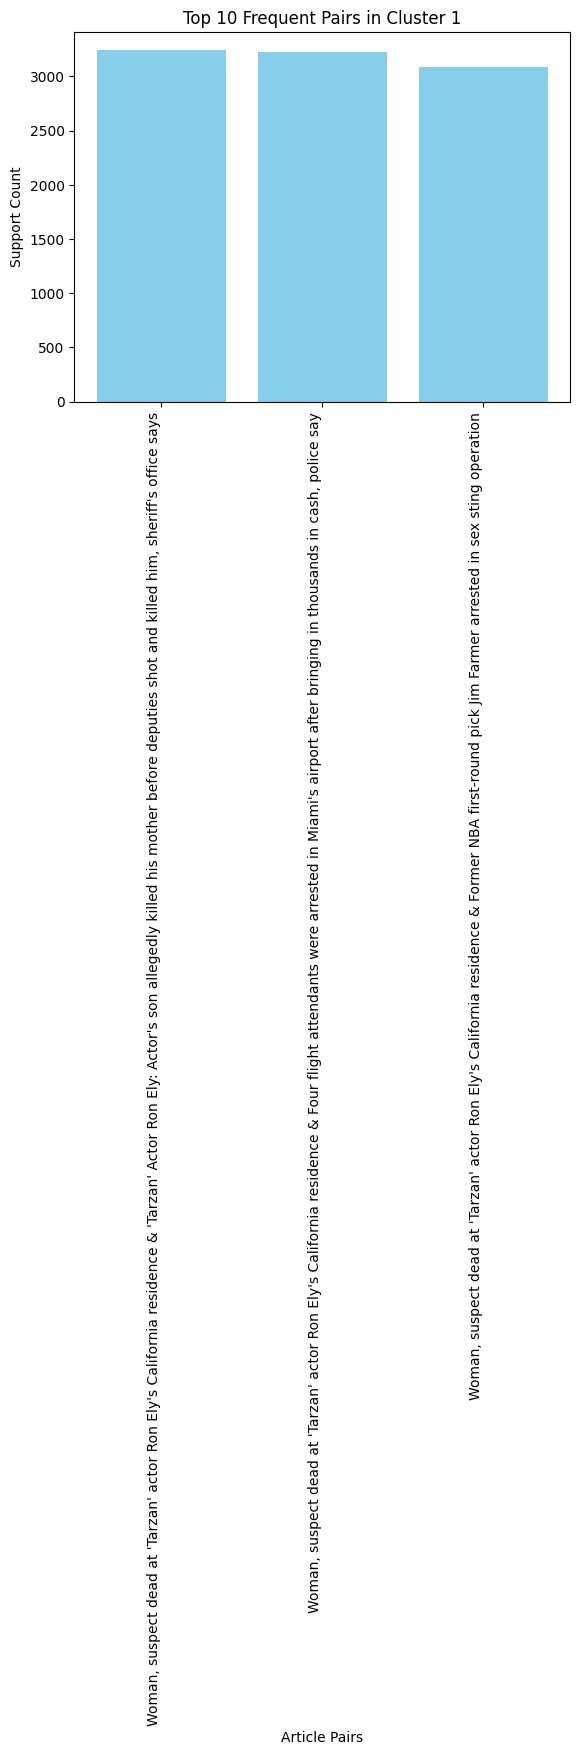

Cluster 3 enthält keine frequent pairs.
Cluster 2 enthält keine frequent pairs.
Cluster 4 enthält keine frequent pairs.


In [20]:
# Map news IDs to clusters for processing user histories
news_cluster_map = dict(zip(news['news_id'], news['cluster']))

# Pass 1 of the PC-Y algorithm: Count individual items and hash pairs
min_support = 3000
hash_table_size = 200000
item_count = defaultdict(int)
hash_table = [0] * hash_table_size

# Count individual items and hash pairs, skipping self-pairs
for basket in baskets:
    for item in basket:
        item_count[item] += 1

    # Generate item pairs using combinations and skip self-pairs
    for pair in combinations(basket, 2):
        # Skip self-pairs
        if pair[0] == pair[1]:
            continue

        hash_index = (hash(pair[0]) + hash(pair[1])) % hash_table_size
        hash_table[hash_index] += 1

# Generate bitmap to filter candidate pairs
bitmap = [1 if count >= min_support else 0 for count in hash_table]
frequent_items = {item for item, count in item_count.items() if count >= min_support}

print(f"Number of frequent items: {len(frequent_items)}")

# Perform clustering analysis on baskets
# Group items into clusters based on the precomputed clusters
clustered_baskets = defaultdict(list)
for basket in baskets:
    clustered_basket = defaultdict(list)
    for item in basket:
        cluster = news_cluster_map.get(item, -1)
        if cluster != -1:
            clustered_basket[cluster].append(item)
    for cluster, items in clustered_basket.items():
        clustered_baskets[cluster].append(items)

# Pass 2 of the PC-Y algorithm: Find frequent pairs within clusters
cluster_frequent_pairs = {}
for cluster, cluster_baskets in clustered_baskets.items():
    candidate_pairs = defaultdict(int)
    for basket in cluster_baskets:
        filtered_basket = [item for item in basket if item in frequent_items]
        for pair in combinations(filtered_basket, 2):
            if pair[0] == pair[1]:
                continue
            hash_index = (hash(pair[0]) + hash(pair[1])) % hash_table_size
            if bitmap[hash_index]:
                candidate_pairs[pair] += 1
    cluster_frequent_pairs[cluster] = {pair: count for pair, count in candidate_pairs.items() if count >= min_support}


# Enrich the frequent pairs with news titles for visualization
cluster_enriched_pairs = {}

for cluster, pairs in cluster_frequent_pairs.items():
    enriched_pairs = []
    for (news_id1, news_id2), count in pairs.items():
        title1 = news_title_dict.get(news_id1, "Unknown Title")
        title2 = news_title_dict.get(news_id2, "Unknown Title")
        enriched_pairs.append((news_id1, title1, news_id2, title2, count))
    cluster_enriched_pairs[cluster] = sorted(enriched_pairs, key=lambda x: x[4], reverse=True)[:10]

# Visualize the results
for cluster, enriched_pairs in cluster_enriched_pairs.items():
    if not enriched_pairs:
        print(f"Cluster {cluster} enthält keine frequent pairs.")
        continue

    # Prepare data for visualization
    pairs = [f"{pair[1]} & {pair[3]}" for pair in enriched_pairs]
    counts = [pair[4] for pair in enriched_pairs]

    # Create bar chart
    plt.bar(pairs, counts, color='skyblue')
    plt.xticks(rotation=90, ha='right')
    plt.xlabel("Article Pairs")
    plt.ylabel("Support Count")
    plt.title(f"Top 10 Frequent Pairs in Cluster {cluster}")
    plt.tight_layout()
    plt.show()

# APriori Algorithm based on Users

In [21]:
# Group by user and get rid of duplicates in the history

old_behaviors["user_id"] = old_behaviors["user_id"].str.lstrip('U')
# Get rid of NaNs
old_behaviors['history'] = old_behaviors['history'].fillna('')

user_histories = []
for user_id, user_data in old_behaviors.groupby('user_id'):
    one_history_string = " ".join(user_data['history'])
    splitted_without_duplicates = set(one_history_string.split())
    articles_list_per_user = list(splitted_without_duplicates)
    user_histories.append(articles_list_per_user)
    
    
# Pass 1
# Store count of each individual item
articles_count = {}

for history in user_histories:
    for article in history:
        if article in articles_count:
            articles_count[article] += 1
        else:
            articles_count[article] = 1
print(articles_count)

# Find frequent items
frequent_articles = {}

threshold = 500 #50.000 histories -> 1% ist 500

for article, count in articles_count.items():
    if count >= threshold:
        frequent_articles[article] = count
        
articles_all = list(news['news_id'])

# Before Pass 2
# Create new array

frequent_singleton_table = {}
map_value = 1

for article in articles_all:
    if article in frequent_articles:
        frequent_singleton_table[article] = map_value
        map_value += 1
    else:
        frequent_singleton_table[article] = 0
        
# Pass 2
# Store pairs of items (articles) that are both frequent (in frequent_articles)

pairs_of_frequent_articles = {}

for history in user_histories:
    frequent_items = []
    for article in history:
        if article in frequent_singleton_table and frequent_singleton_table[article] > 0:
            frequent_items.append(article)

    for i in range(len(frequent_items)):
        for j in range(i + 1, len(frequent_items)):
            article1, article2 = sorted((frequent_items[i], frequent_items[j]))
            pair = (article1, article2)

            if pair in pairs_of_frequent_articles:
                pairs_of_frequent_articles[pair] += 1
            else:
                pairs_of_frequent_articles[pair] = 1

min_support = 500
frequent_pairs = {}
for triplet, count in pairs_of_frequent_articles.items():
    if count >= min_support:
        frequent_pairs[triplet] = count
        
sorted_pairs = sorted(pairs_of_frequent_articles.items(), key=lambda x: x[1], reverse=True)
top_10_pairs = sorted_pairs[:10]

for pair, count in top_10_pairs:
    print(f"Pair: {pair}, Count: {count}")
    
    
for pair, count in top_10_pairs:
    article1_id, article2_id = pair

    title1 = news.loc[news['news_id'] == article1_id, 'title'].values[0]
    title2 = news.loc[news['news_id'] == article2_id, 'title'].values[0]
    
    # Print the pair with titles and count
    print(article1_id, "(" , title1, ") \n", article2_id, "(", title2, ") \n Count: ", count)
    print("\n")    
    
# 3 set
triplets_of_frequent_articles = {}
frequent_triplets = {}

for history in user_histories:
    frequent_items = []
    for article in history:
        if frequent_singleton_table.get(article, 0) > 0:
            frequent_items.append(article)

    for i in range(len(frequent_items)):
        for j in range(i + 1, len(frequent_items)):
            for k in range(j + 1, len(frequent_items)):
                article1, article2, article3 = sorted((frequent_items[i], frequent_items[j], frequent_items[k]))
                triplet = (article1, article2, article3)

                if article1 in frequent_singleton_table and article2 in frequent_singleton_table and article3 in frequent_singleton_table:
                    if triplet in triplets_of_frequent_articles:
                        triplets_of_frequent_articles[triplet] += 1
                    else:
                        triplets_of_frequent_articles[triplet] = 1

min_support = 140
for triplet, count in triplets_of_frequent_articles.items():
    if count >= min_support:
        frequent_triplets[triplet] = count

# 4 set
quadruples_of_frequent_articles = {}
frequent_quadruples = {}

for history in user_histories:
    frequent_items = []
    for article in history:
        if frequent_singleton_table.get(article, 0) > 0:
            frequent_items.append(article)

    for i in range(len(frequent_items)):
        for j in range(i + 1, len(frequent_items)):
            for k in range(j + 1, len(frequent_items)):
                for o in range(k + 1, len(frequent_items)):
                    article1, article2, article3, article4 = sorted((frequent_items[i], frequent_items[j], frequent_items[k], frequent_items[o]))
                    quadruple = (article1, article2, article3, article4)

                    if article1 in frequent_singleton_table and article2 in frequent_singleton_table and article3 in frequent_singleton_table and article4 in frequent_singleton_table:
                        if quadruple in quadruples_of_frequent_articles:
                            quadruples_of_frequent_articles[quadruple] += 1
                        else:
                            quadruples_of_frequent_articles[quadruple] = 1

min_support = 10
for quadruple, count in quadruples_of_frequent_articles.items():
    if count >= min_support:
        frequent_quadruples[quadruple] = count

{'N51705': 468, 'N18870': 2232, 'N20575': 964, 'N42330': 222, 'N50095': 1, 'N33998': 450, 'N45954': 754, 'N20121': 935, 'N55743': 2193, 'N53465': 82, 'N1789': 23, 'N29641': 264, 'N41244': 410, 'N56814': 34, 'N56447': 727, 'N27256': 3, 'N46444': 63, 'N51706': 2441, 'N61319': 604, 'N33976': 429, 'N18030': 576, 'N34562': 4, 'N20639': 1, 'N22816': 1356, 'N27644': 561, 'N2735': 619, 'N59380': 302, 'N47937': 2, 'N26619': 49, 'N28257': 1473, 'N41668': 1, 'N1282': 1, 'N61052': 1, 'N50839': 120, 'N39074': 216, 'N31431': 9, 'N45336': 24, 'N9619': 29, 'N46754': 26, 'N52496': 1, 'N38390': 173, 'N23912': 84, 'N10376': 44, 'N36526': 142, 'N5812': 5, 'N60000': 127, 'N30148': 1, 'N40977': 180, 'N63422': 1, 'N29207': 71, 'N38870': 63, 'N33117': 72, 'N44495': 508, 'N35304': 25, 'N63049': 178, 'N23614': 728, 'N59704': 2018, 'N32312': 987, 'N33876': 1, 'N56253': 701, 'N31304': 147, 'N53827': 17, 'N37059': 43, 'N16290': 723, 'N52555': 515, 'N9824': 303, 'N40442': 800, 'N19979': 63, 'N52109': 35, 'N13374': 

# APriori Algorithm based on Clusters

Top-10 Frequent Singletons:
[]
Top-10 Frequent Pairs:
Top-10 Frequent Triplets:
Top-10 Frequent Quadruplets:


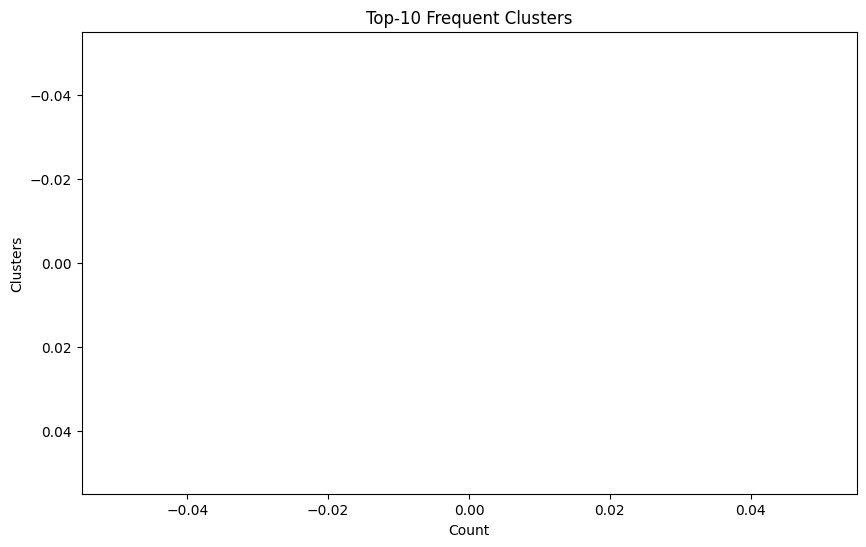

In [23]:
clustered_histories = []
for history in old_behaviors['history']:
    clustered_history = []
    for item in history:
        cluster = news_cluster_map.get(item, -1)  # Map article ID to its cluster
        if cluster != -1:
            clustered_history.append(f"cluster_{cluster}")  # Represent the cluster as "cluster_X"
    clustered_histories.append(clustered_history)

# User histories without duplicates per user
user_histories = []
for history in clustered_histories:
    user_histories.append(list(set(history)))

# Frequent Itemset Mining

# 1. Count frequency of singletons (clusters)
singleton_count = {}
for history in user_histories:
    for cluster in history:
        singleton_count[cluster] = singleton_count.get(cluster, 0) + 1

# Define minimum support
min_support = 500

# Select frequent singletons (clusters) based on minimum support
frequent_singletons = {item: count for item, count in singleton_count.items() if count >= min_support}

# 2. Analyze pairs (cluster combinations)
pair_count = {}
for history in user_histories:
    frequent_items = [item for item in history if item in frequent_singletons]
    for i in range(len(frequent_items)):
        for j in range(i + 1, len(frequent_items)):
            pair = tuple(sorted((frequent_items[i], frequent_items[j])))
            pair_count[pair] = pair_count.get(pair, 0) + 1

# Select frequent pairs based on minimum support
frequent_pairs = {pair: count for pair, count in pair_count.items() if count >= min_support}

# 3. Analyze triplets
triplet_count = {}
for history in user_histories:
    frequent_items = [item for item in history if item in frequent_singletons]
    for i in range(len(frequent_items)):
        for j in range(i + 1, len(frequent_items)):
            for k in range(j + 1, len(frequent_items)):
                triplet = tuple(sorted((frequent_items[i], frequent_items[j], frequent_items[k])))
                triplet_count[triplet] = triplet_count.get(triplet, 0) + 1

# Select frequent triplets based on minimum support
frequent_triplets = {triplet: count for triplet, count in triplet_count.items() if count >= min_support}

# 4. Analyze quadruplets
quadruplet_count = {}
for history in user_histories:
    frequent_items = [item for item in history if item in frequent_singletons]
    for i in range(len(frequent_items)):
        for j in range(i + 1, len(frequent_items)):
            for k in range(j + 1, len(frequent_items)):
                for l in range(k + 1, len(frequent_items)):
                    quadruplet = tuple(sorted((frequent_items[i], frequent_items[j], frequent_items[k], frequent_items[l])))
                    quadruplet_count[quadruplet] = quadruplet_count.get(quadruplet, 0) + 1

# Select frequent quadruplets based on minimum support
frequent_quadruplets = {quadruplet: count for quadruplet, count in quadruplet_count.items() if count >= min_support}

# Display results
print("Top-10 Frequent Singletons:")
print(sorted(frequent_singletons.items(), key=lambda x: x[1], reverse=True)[:10])

print("Top-10 Frequent Pairs:")
top_10_pairs = sorted(frequent_pairs.items(), key=lambda x: x[1], reverse=True)[:10]
for pair, count in top_10_pairs:
    print(f"Pair: {pair}, Count: {count}")

print("Top-10 Frequent Triplets:")
top_10_triplets = sorted(frequent_triplets.items(), key=lambda x: x[1], reverse=True)[:10]
for triplet, count in top_10_triplets:
    print(f"Triplet: {triplet}, Count: {count}")

print("Top-10 Frequent Quadruplets:")
top_10_quadruplets = sorted(frequent_quadruplets.items(), key=lambda x: x[1], reverse=True)[:10]
for quadruplet, count in top_10_quadruplets:
    print(f"Quadruplet: {quadruplet}, Count: {count}")

# Visualization of frequent clusters
top_clusters = sorted(frequent_singletons.items(), key=lambda x: x[1], reverse=True)[:10]
top_clusters_labels = [item[0] for item in top_clusters]
top_clusters_counts = [item[1] for item in top_clusters]

plt.figure(figsize=(10, 6))
plt.barh(top_clusters_labels, top_clusters_counts, color='skyblue')
plt.xlabel('Count')
plt.ylabel('Clusters')
plt.title('Top-10 Frequent Clusters')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()